# Identifying Entities in Healthcare Data

## Syntactic Processing - Assignment

### Step_0 >>>  Set up environment : Import and Install useful packages and libraries

In [1]:
from platform import python_version
print(python_version())

3.9.12


In [2]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
model = spacy.load("en_core_web_sm")

## Step 1 >>> Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

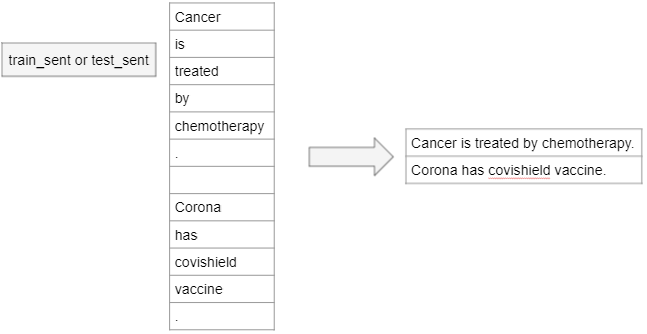

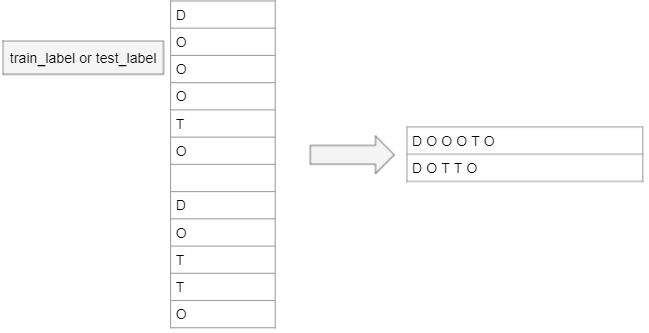

In [3]:
# Write a function that processes the file and returns a list of sentences.

def preprocess_inputfile(input_file):
    i_file = open(input_file, 'r')
    file_name = i_file.readlines()
    i_file.close()

    output_list = []

    full_sentence = ""

    for each_word in file_name:
        each_word = each_word.strip()
        if each_word == "":
            output_list.append(full_sentence) 
            full_sentence = "" # For new sentence to start
        else:
            if full_sentence:
                full_sentence += " " + each_word
            else:
                full_sentence = each_word
                
    return output_list

In [4]:
train_sentences = preprocess_inputfile('train_sent')
train_labels = preprocess_inputfile('train_label')
test_sentences = preprocess_inputfile('test_sent')
test_labels = preprocess_inputfile('test_label')

### Step 1.1 --> To print first five sentences from the processed dataset

In [5]:
for each_item in range(5):
    print(f"Sentence {each_item+1} is: {train_sentences[each_item]}")
    print(f"Label {each_item+1} is: {train_labels[each_item]}")
    print("\n")

Sentence 1 is: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Label 1 is: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


Sentence 2 is: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Label 2 is: O O O O O O O O O O O O O O O O O O O O O O O O O


Sentence 3 is: Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Label 3 is: O O O O O O O O O O O O O O O


Sentence 4 is: The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Label 4 is: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


Sentence 5 is: Arrest of dilation was the

### Step 1.2 --> Count the number of sentences in the processed train and test dataset 

In [6]:
print(f"Total number of sentences in processed train dataset is: {len(train_sentences)}")
print(f"Total number of sentences in processed test dataset is: {len(test_sentences)}")

Total number of sentences in processed train dataset is: 2599
Total number of sentences in processed test dataset is: 1056


### Step 1.3 --> Count the number of lines of labels in the processed train and test dataset.

In [7]:
print(f"Number of lines of labels in processed train dataset is: {len(train_labels)}")
print(f"Number of lines of labels in processed test dataset is: {len(test_labels)}")

Number of lines of labels in processed train dataset is: 2599
Number of lines of labels in processed test dataset is: 1056


# Step 2 -->  Concept Identification

First, we will explore the different concepts present in the dataset by using Part-of-Speech (PoS) tagging.

### Step 2.1 --> Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [8]:
# Creating a list to store all tokens that are either NOUN or PROPER NOUN
noun_propn_tokens_list = []

In [9]:
# Each token which is a NOUN or PROPN will be appended to the list "noun_propn_tokens_list"

for sentences in (train_sentences, test_sentences):
    for sent in sentences:
        processed_sent = model(sent)
        for each_token in processed_sent:
            if each_token.pos_ == "NOUN" or each_token.pos_ == "PROPN":
                noun_propn_tokens_list.append(each_token.text)

In [10]:
# Creating a series to store the tokens that are either NOUN or PROPER NOUN
df_noun_propn = pd.Series(noun_propn_tokens_list)

### Step 2.2 --> Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [11]:
# Counting the occurrences of each token and then sorting the data to get the top 25 tokens with the highest counts.

df_noun_propn.value_counts().sort_values(ascending=False).head(25)

patients        492
treatment       281
%               247
cancer          200
therapy         175
study           154
disease         142
cell            140
lung            116
group            94
chemotherapy     88
gene             87
effects          85
results          79
women            77
use              74
TO_SEE           74
risk             71
cases            71
surgery          71
analysis         70
rate             67
response         66
survival         65
children         64
Name: count, dtype: int64

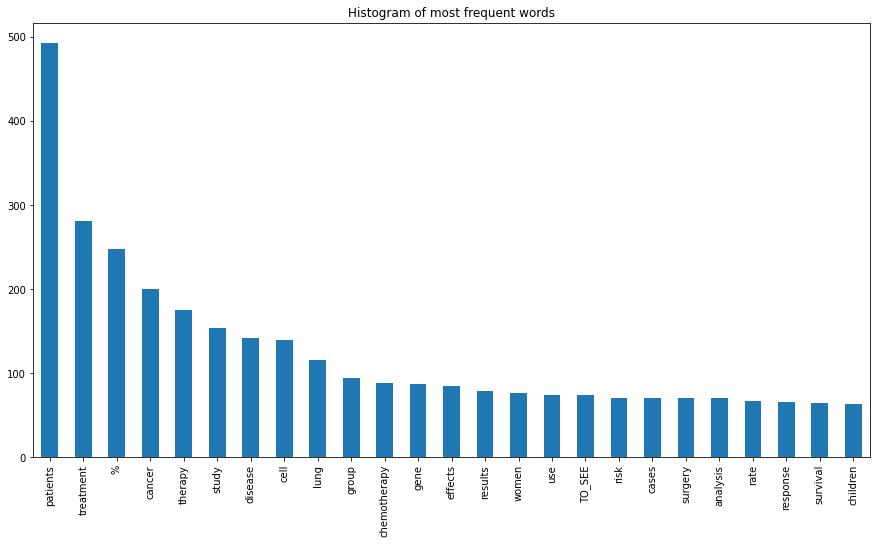

In [12]:
# plotting most frequent words for EDA
plt.figure(figsize=(15,8)) 
top_25 = df_noun_propn.value_counts().sort_values(ascending=False).head(25)
ax = top_25.plot.bar()
ax.set_title('Histogram of most frequent words')
plt.show()

### INFERENCE:
- The graph indicate that the data primarily revolves around cancer and chemotherapy
- The data also reveals that diseases affecting women are more prevalent, followed by those affecting children
- The most commonly affected organ appears to be the lungs

# Step 3 -->  Defining Features for CRF

In [13]:
# we will define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos, pos_tags):
  word = sentence[pos]

  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos]
  ]
    
    
#Let us use the previous word as well while defining features
  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_word.pos=' + pos_tags[pos-1]
  ])
  # Mark the begining and the end words of a sentence correctly in the form of features.
  else:
    features.append('BEG') # feature to track begin of sentence 

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features

# Step 4 -->  Getting the Features

### Step 4.1 -->  Write a code/function to get the features for a SENTENCE

In [14]:
# Let us write a code to get features for a sentence.

def getFeaturesForOneSentence(sentence):
    
    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    
    for each_token in processed_sent:
        postags.append(each_token.pos_)
    
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags) for pos in range(len(sentence_list))]


### Step 4.2 --> Write a code/function to get the LABELS of a sentence

In [15]:
# Write a code to get the labels for a sentence.

def getLabelsInListForOneSentence(labels):
  return labels.split()


# Step 5 -->  Define Input and Target Variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Step 5.1 --> Define the Features' Values for each sentence as Input Variable  for CRF model in test and the train dataset 

In [16]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

### Define the labels as the target variable for test and the train dataset

In [17]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

# Step 6 --> Build the CRF Model

In [18]:
# Build the CRF model.

crf = sklearn_crfsuite.CRF(max_iterations=100)
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass


# Step 7 -->  Evaluation

### Step 7.1 Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [19]:
Y_pred = crf.predict(X_test)

### Step 7.2 --> Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [20]:
f1_score = metrics.flat_f1_score(Y_test, Y_pred, average='weighted')
print('F1 Score is : {0} % '.format(round(f1_score*100,2)))

precision = metrics.flat_precision_score(Y_test, Y_pred, average='weighted')
recall  = metrics.flat_recall_score(Y_test, Y_pred, average='weighted')
accuracy = metrics.flat_accuracy_score(Y_test, Y_pred)
print('Precision score is : {0} % '.format(round(precision*100,2)))
print('Recall score is : {0} % '.format(round(recall*100,2)))
print('Accuracy score is : {0} % '.format(round(accuracy*100,2)))

F1 Score is : 90.53 % 
Precision score is : 90.65 % 
Recall score is : 91.44 % 
Accuracy score is : 91.44 % 


# Step 8 --> Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Step 8.1 --> Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset

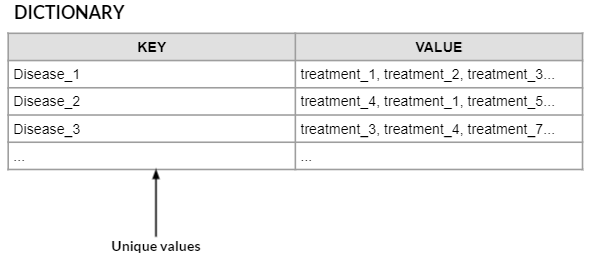

In [21]:
print(Y_pred)

[list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])
 list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])
 list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])
 ... list(['T', 'T', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'D'])
 list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'D'])
 list(['T', 'T', 'T', 'O', 'O', 'O', 'O'])]


In [22]:
# Creating an empty dictionary to hold diseases and their corresponding treatments
D_T_dict = dict()

for i in range(len(Y_pred)):
    # Get the predicted labels of each test sentence into "val"
    val = Y_pred[i]
    
    # Empty strings to store the values of Diseases and Treatments
    Diseases = ""
    Treatments = ""
    
    # Each loop will iterate through the individual labels and focus on mapping D and T labels
    # with Diseases and Treatments within each sentence into a concatenated string
    for j in range(len(val)):
        if val[j] == 'D': # If label is D, it indicates a Disease 
            Diseases += test_sentences[i].split()[j] + " "
        elif val[j] == 'T': # If label is T, it indicates a Treatment
            Treatments += test_sentences[i].split()[j] + " "
            
    # Removes any extra whitespaces to either end of the string
    Diseases = Diseases.lstrip().rstrip()
    Treatments = Treatments.lstrip().rstrip()

    # If Diseases and Treatments are blank, ignore them
    # If Disease is not present in Dictionary, add it along with the corresponding treatment
    # If Disease is present in the Dictionary, append the treatments for that diseases with existing
    # treatments
    if Diseases != "" and Treatments != "":
        if Diseases in D_T_dict.keys():
            treat_out = list(D_T_dict[Diseases])
            treat_out.append(Treatments)
            D_T_dict[Diseases] = treat_out
        elif Diseases not in D_T_dict.keys():
            D_T_dict[Diseases] = Treatments

In [23]:
# lets view some records from Dictionary 
Disease_Treatment_df = pd.DataFrame(columns=['Diseases','Treatment'])
i = 0
for k, v in D_T_dict.items():
  l = [k, v]
  Disease_Treatment_df.loc[len(Disease_Treatment_df.index)] = l
Disease_Treatment_df.head(5)

,Diseases,Treatment
0,hereditary retinoblastoma,radiotherapy
1,myocardial infarction,"warfarin with 80 mg aspirin , or 1 mg warfarin..."
2,unstable angina,roxithromycin
3,coronary-artery disease,Antichlamydial antibiotics
4,primary pulmonary hypertension ( PPH ),fenfluramines


### Step 8.2 --> Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [24]:
D_T_dict['hereditary retinoblastoma']

'radiotherapy'